In [1]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
print(test.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [4]:
PassengerId = test['PassengerId']
print(PassengerId.ravel())

[ 892  893  894  895  896  897  898  899  900  901  902  903  904  905
  906  907  908  909  910  911  912  913  914  915  916  917  918  919
  920  921  922  923  924  925  926  927  928  929  930  931  932  933
  934  935  936  937  938  939  940  941  942  943  944  945  946  947
  948  949  950  951  952  953  954  955  956  957  958  959  960  961
  962  963  964  965  966  967  968  969  970  971  972  973  974  975
  976  977  978  979  980  981  982  983  984  985  986  987  988  989
  990  991  992  993  994  995  996  997  998  999 1000 1001 1002 1003
 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017
 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031
 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045
 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059
 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071 1072 1073
 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087
 1088 

In [5]:
original_train = train.copy() # Using 'copy()' allows to clone the dataset
full_data = [train, test]

In [6]:
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

train['Cabin'].ravel()

array([nan, 'C85', nan, 'C123', nan, nan, 'E46', nan, nan, nan, 'G6',
       'C103', nan, nan, nan, nan, nan, nan, nan, nan, nan, 'D56', nan,
       'A6', nan, nan, nan, 'C23 C25 C27', nan, nan, nan, 'B78', nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, 'D33', nan, 'B30', 'C52', nan, nan, nan,
       nan, nan, 'B28', 'C83', nan, nan, nan, 'F33', nan, nan, nan, nan,
       nan, nan, nan, nan, 'F G73', nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, 'C23 C25 C27', nan, nan, nan, 'E31', nan,
       nan, nan, 'A5', 'D10 D12', nan, nan, nan, nan, 'D26', nan, nan,
       nan, nan, nan, nan, nan, 'C110', nan, nan, nan, nan, nan, nan, nan,
       'B58 B60', nan, nan, nan, nan, 'E101', 'D26', nan, nan, nan,
       'F E69', nan, nan, nan, nan, nan, nan, nan, 'D47', 'C123', nan,
       'B86', nan, nan, nan, nan, nan, nan, nan, nan, 'F2', nan, nan,
       'C2', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [7]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

In [8]:
# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

In [9]:
print(age_avg)
print(age_std)
print(age_null_count)

30.272590361445783
14.18120923562442
86


In [10]:
#dataset['Age'].isnull().ravel()

In [11]:
np.isnan(dataset['Age']).ravel()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [12]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [13]:
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} )

In [14]:
# Mapping titles
title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
dataset['Title'] = dataset['Title'].map(title_mapping)
dataset['Title'] = dataset['Title'].fillna(0)

# Mapping Embarked
dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# Mapping Fare
dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
dataset['Fare'] = dataset['Fare'].astype(int)

# Mapping Age
dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [15]:
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].fillna(9) 

In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,NaN,S,0,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,C,1,2,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,S,1,2,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,NaN,S,0,1,1,Mr


In [17]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [18]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,0,1,1,1
1,3,0,2,0,0,0,0,2,0,3
2,2,1,3,0,1,2,0,1,1,1
3,3,1,1,0,1,0,0,1,1,1
4,3,0,1,1,1,0,0,3,0,3


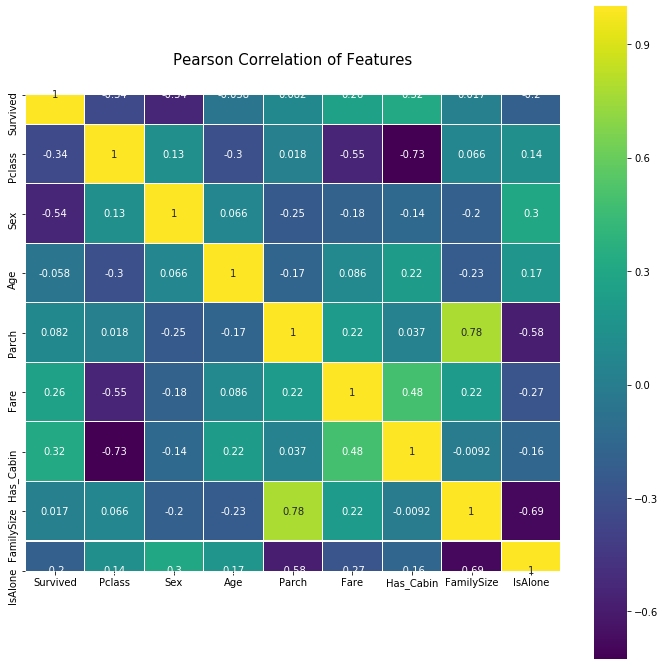

In [19]:
#Our dataset is now much cleaner than before, with only numerical values and potentially meaningful features.
#Let's now explore the relationship between our variables by plotting the Pearson Correlation between all the attributes
#in our dataset


colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [20]:
#Finding best tree depth with the help of Cross Validation



In [21]:
#Final Tree

# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
#y_pred = decision_tree.predict(x_test)

ValueError: could not convert string to float: 'S'

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(decision_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
                                      
Image(graph.create_png())